In [127]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,eye,bmat
from scipy.sparse.linalg import eigs,gmres
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
%matplotlib inline

In [128]:
data = pd.read_csv('data/round_train.csv')
data1 = pd.read_csv('data/round_test.csv',header=None)
data1.columns = data.columns
data = pd.concat([data,data1])

In [129]:
data.shape

(231125, 12)

In [130]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [131]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [132]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [176]:
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])

In [134]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)

In [135]:
print n_players,n_rounds

2461 2549


In [136]:
def alpha(A,a):
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [137]:
def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [138]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [220]:
cmats = {}
def inflate(round_group,bin_size,BETA,window_size):
    n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
    mat = csc_matrix((n_players*n_round_groups,n_players),dtype=float)
    mat_1 = csc_matrix((n_players*n_round_groups,n_players),dtype=float)
    for j in range(bin_size):
        mat += bmat([[load_sparse_csc('rounds/%d.npz' % (round_group*j))*my_norm(round_group-k,BETA)] for k in range(1,n_round_groups+1)],format='csc')
        mat_1 += bmat([[(load_sparse_csc('rounds/%d.npz' % (round_group*j))!=0).astype(float)*my_norm(round_group-k,BETA)] for k in range(1,n_round_groups+1)],format='csc')
    cmats[round_group] = (mat,mat_1)
#     if round_group>window_size and round_group%5:
#         for i in range(1,round_group+1):
#             inflate.__dict__[round_group] = (inflate.__dict__[round_group][0][n_players:],inflate.__dict__[round_group][1][n_players:])
    if round_group==1:
        inflate.__dict__['main_mat'] = cmats[1][0][0:n_players]
        inflate.__dict__['main_mat1'] = cmats[1][1][0:n_players]
    else:
        temp = bmat([[cmats[i][0][n_players*(round_group-1):n_players*round_group] for i in range(max(1,round_group-window_size+1),round_group)]],format='csc')
        temp1 = bmat([[cmats[i][1][n_players*(round_group-1):n_players*round_group] for i in range(max(1,round_group-window_size+1),round_group)]],format='csc')
        inflate.__dict__['main_mat'] = bmat([[inflate.__dict__['main_mat'][n_players if round_group>window_size else 0:,n_players if round_group>window_size else 0:],cmats[round_group][0][max(0,round_group-window_size)*n_players:n_players*(round_group-1)]],
                                             [temp,cmats[round_group][0][n_players*(round_group-1):n_players*round_group]]],format='csc')
        inflate.__dict__['main_mat1'] = bmat([[inflate.__dict__['main_mat1'][n_players if round_group>window_size else 0:,n_players if round_group>window_size else 0:],cmats[round_group][1][max(0,round_group-window_size)*n_players:n_players*(round_group-1)]],
                                             [temp,cmats[round_group][1][n_players*(round_group-1):n_players*round_group]]],format='csc')
    return (inflate.__dict__['main_mat'],inflate.__dict__['main_mat1'])

In [221]:
def solve(mat,mat_1,a,x_guess=None,x_guess1=None):
    S = eye(mat.shape[0],format='csc')-alpha(mat,a)*mat
    w_a = gmres(S,mat.sum(1),x0=x_guess)[0]
    solve.w_a = w_a
    
    S = eye(mat_1.shape[0],format='csc')-alpha(mat_1,a)*mat_1
    w_g = gmres(S,mat_1.sum(1),x0=x_guess1)[0]
    solve.w_g = w_g
    
    return ((w_a/w_g)[-n_players:],w_g[-n_players:])

In [222]:
ranks,reps = [],[]
BETA = 7
a = .8
bin_size = 16
window_size = 30
n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
print n_round_groups
current_group = 0
tournaments=[set()]
for round_ind,df in enumerate(rounds):
    df = df[1]
    round_group = round_ind/bin_size
    if round_group>current_group:
        A,G = inflate(round_group,bin_size,BETA,window_size)
        if current_group==0:
            rank,rep = solve(A,G,a)
            ranks.append(rank)
            reps.append(rep)
            print 'Round Group %d done' % round_group
            current_group = round_group
            tournaments.append(set())
        else:
            w_a_approx = np.append(solve.w_a[0 if round_group<=window_size else n_players:],solve.w_a[-n_players:])
            w_g_approx = np.append(solve.w_g[0 if round_group<=window_size else n_players:],solve.w_g[-n_players:])
            rank,rep = solve(A,G,a,w_a_approx,w_g_approx)
            ranks.append(rank)
            reps.append(rep)
            print 'Round Group %d done' % round_group
            current_group = round_group
            tournaments.append(set())
    tournaments[current_group].update([df.iloc[0]['Permanent_Tournament_#']])

160
Round Group 1 done
Round Group 2 done
Round Group 3 done
Round Group 4 done
Round Group 5 done
Round Group 6 done
Round Group 7 done
Round Group 8 done
Round Group 9 done
Round Group 10 done
Round Group 11 done
Round Group 12 done
Round Group 13 done
Round Group 14 done
Round Group 15 done
Round Group 16 done
Round Group 17 done
Round Group 18 done
Round Group 19 done
Round Group 20 done
Round Group 21 done
Round Group 22 done
Round Group 23 done
Round Group 24 done
Round Group 25 done
Round Group 26 done
Round Group 27 done
Round Group 28 done
Round Group 29 done
Round Group 30 done
Round Group 31 done
Round Group 32 done
Round Group 33 done
Round Group 34 done
Round Group 35 done
Round Group 36 done
Round Group 37 done
Round Group 38 done
Round Group 39 done
Round Group 40 done
Round Group 41 done
Round Group 42 done
Round Group 43 done
Round Group 44 done
Round Group 45 done
Round Group 46 done
Round Group 47 done
Round Group 48 done
Round Group 49 done
Round Group 50 done
Round

In [223]:
import pickle

In [224]:
with open('tournaments.pkl', 'w') as picklefile:
    pickle.dump(tournaments, picklefile)

with open('ranks.pkl', 'w') as picklefile:
    pickle.dump(ranks, picklefile)
    
with open('reps.pkl', 'w') as picklefile:
    pickle.dump(reps, picklefile)

In [ ]:
with open("my_data.pkl", 'r') as picklefile: 
    my_old_data = pickle.load(picklefile)

In [16]:
for i in range(1,len(tournaments)):
    tournaments[i] = tournaments[i]-tournaments[i-1]

In [17]:
tournaments

[{2, 3, 6, 16},
 {1, 4, 5, 7},
 {8, 9, 10, 11},
 {12, 14, 20, 22},
 {18, 19, 21, 480},
 {23, 24, 26, 27},
 {25, 28, 29, 37},
 {33, 34, 35, 100},
 {32, 472, 476, 505},
 {30, 41, 54, 474},
 {13, 45, 47, 473},
 {6, 16, 60, 475},
 {2, 3, 4, 5},
 {1, 7, 8, 10},
 {9, 11, 14, 22},
 {12, 18, 20, 480},
 {19, 21, 23, 25},
 {24, 26, 27, 28},
 {29, 30, 37, 100},
 {33, 35, 472, 476},
 {32, 34, 41, 505},
 {47, 54, 473, 474},
 {13, 45, 60, 475},
 {2, 4, 6, 16},
 {1, 3, 5, 7},
 {8, 9, 10, 11},
 {12, 14, 20, 22},
 {18, 19, 21, 480},
 {23, 24, 25, 26},
 {27, 28, 30, 37},
 {29, 33, 35, 100},
 {34, 472, 476, 505},
 {13, 32, 41, 474},
 {45, 47, 473, 475},
 {6, 16, 54, 60},
 {2, 3, 4, 5},
 {1, 7, 8, 10},
 {9, 11, 14, 22},
 {12, 18, 20, 480},
 {19, 21, 23, 25},
 {24, 26, 27, 34},
 {28, 30, 37, 100},
 {29, 33, 35, 472},
 {32, 474, 476, 505},
 {13, 41, 54, 473},
 {45, 47, 60, 475},
 {2, 4, 6, 16},
 {3, 5, 7, 457},
 {9, 10, 473, 475},
 {12, 14, 18, 20},
 {11, 19, 22, 480},
 {21, 23, 25, 26},
 {30, 34, 35, 471},

In [18]:
ols = LinearRegression()
iso = IsotonicRegression(increasing=False)

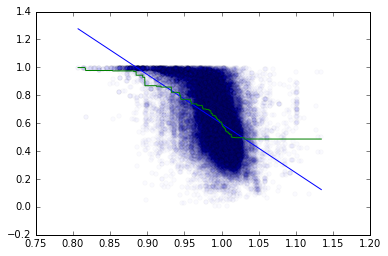

In [19]:
ratings,outcomes = [],[]
for t_ind in range(1,len(tournaments)):
    sub = data[data['Permanent_Tournament_#'].isin(tournaments[t_ind])]
    df1 = pd.DataFrame(sub.groupby(['Player_Index','Permanent_Tournament_#'],as_index=False)['Finishing_Pct'].mean())
    df1 = pd.DataFrame(df1.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame(ranks[t_ind-1],columns=['rating'])
    df = df1.merge(df2,left_index=True,right_index=True).dropna()
    ratings += df.rating.values.tolist()
    outcomes += df.Finishing_Pct.values.tolist()
a,b = .7,.3
for i in range(len(ranks)):
    df = pd.DataFrame({'rank':ranks[i],'reps':reps[i]})
    pct_reps = pd.Series(reps[i][reps[i]!=0]).rank(pct=True).tolist()
    df.insert(len(df.columns),'pct_reps',[0]*len(df))
    df.ix[df.reps!=0,'reps_pct'] = pct_reps
    df.insert(len(df.columns),'coeff',[sph(rep_pct,a,b) for rep_pct in df.reps_pct])
    df.insert(len(df.columns),'new_rank',df['rank']*df.coeff)
ratings,outcomes = np.array(ratings),np.array(outcomes)
ols.fit(ratings[:,None],outcomes)
iso.fit(ratings,outcomes)
predictions_o = ols.predict(np.sort(ratings)[:,None])
predictions_i = iso.predict(np.sort(ratings))
plt.scatter(ratings,outcomes,alpha=.02)
plt.plot(np.sort(ratings),predictions_o)
plt.plot(np.sort(ratings),predictions_i)
plt.show()

In [20]:
np.corrcoef(ratings,outcomes)

array([[ 1.        , -0.50523043],
       [-0.50523043,  1.        ]])

In [21]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [22]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[99][-n_players:]}).sort_values('rank',ascending=False)

,player_ind,player_name,rank
897,897,"Siem, Marcel",1.105869
1341,1341,"Zanotti, Fabrizio",1.103857
860,860,"Bradshaw, Paul",1.095167
841,841,"Felton, Kim",1.095167
543,543,"Brier, Markus",1.084193
1795,1795,"Langley, Scott",1.083864
1004,1004,"Parel, Scott",1.081456
877,877,"Coston, Jeff",1.076565
1836,1836,"Lee, Beon Yeong",1.069812
828,828,"Lane, Barry",1.068430


In [23]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [24]:
inds_to_plot = [names_to_ind['Woods, Tiger'],names_to_ind['Singh, Vijay']]

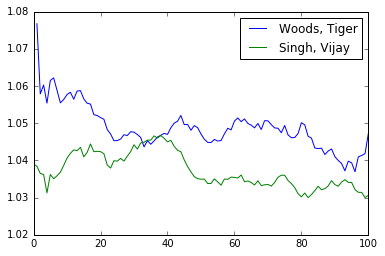

In [25]:
for j in inds_to_plot:
    plt.plot([ranks[i][j] for i in range(101)],label = inds_to_name[j]);
plt.legend();

In [26]:
len(ranks)

102

In [27]:
len(reps)

102

In [33]:
print len(reps[89])
print len(reps[89][reps[89]!=0])

2461
1587


In [49]:
def sph(x,a,b):
    if x<a:
        return min(1,b + 1.5*(x/a) - .5*(x/a)**3)
    else:
        return 1